In [103]:
import scipy
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import Basemap
import os
from scipy.io import loadmat, savemat
from matplotlib.colors import LogNorm
import math

In [104]:
# dictionary = np.load('2015/Fall.npz', allow_pickle = True)
# FallData = dictionary.item()

# dictionary = np.load('2015/Spring.npz', allow_pickle = True)
# SpringData = dictionary.item()

# dictionary = np.load('2015/Summer.npz', allow_pickle = True)
# SummerData = dictionary.item()

#dictionary = np.load('2015/Winter.npz', allow_pickle = True)
# print(dictionary["H"][0])
# print(len(dictionary["XX"]))
# print(len(dictionary["YY"]))

In [105]:
# filepath = '/Volumes/lairdata/lightningdata/GLD_cleaned/2017-11-27/GLD-201711270000-cleaned.mat'
# mat = loadmat(filepath).get("flashes") # not used, not used, latitude, longitude, peak current 

In [106]:
# dictionary = np.load('2015/Summer.npz', allow_pickle = True)

In [107]:
'This functions returns a 2D array containing the peak current density of each bin'
def computeCurrentDensity(dictionary):
       # H is the values in each bin
       # xedges are the bin edges along 1st dimension (lon)
       # yedges are the ones along 2nd dimension (lat)
       # for the count statistic, values not referenced since count computes count of points (lat lon coordinates) in each bin
       # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binned_statistic_2d.html

       # meshgrid returns 2d array 
       # XX is the lon values: 2d array containing 100 arrays of the same xedges (lon values) 
       # YY is the lat values: 2d array containing 100 arrays from lowest to highest with each array containing 100 of the same values

       xedges = dictionary["XX"][0]
       yedges = dictionary["YY"][:,1]
       H = dictionary["H"]
       H = np.ma.masked_where(H==0, H) # wamasking where there was no data

       newH = []
       for j in range(len(H.T)):
              latCoordinate1 = yedges[j]
              latCoordinate2 = yedges[j+1]
              averageAtLat = H.T[j]
              placeholder = []
              for i in range(len(H.T)):  
                     lonCoordinate1 = xedges[i]
                     lonCoordinate2 = xedges[i+1]

                     # compute area of one bin using haversine formula 
                     binArea = 1 
                     R = 6371e3; # meters
                     
                     # compute dist btw 2 latitudes
                     φ1 = latCoordinate1 * math.pi/180 # lat and lon in radians
                     φ2 = latCoordinate2 * math.pi/180 
                     Δφ = (latCoordinate2-latCoordinate1) * math.pi/180
                     Δλ = (lonCoordinate1-lonCoordinate1) * math.pi/180
                     a = math.sin(Δφ/2) * math.sin(Δφ/2) + math.cos(φ1) * math.cos(φ2) * math.sin(Δλ/2) * math.sin(Δλ/2)
                     c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
                     d1 = (R * c) / 1000; # dist in metres

                     # compute dist btw 2 longitudes
                     φ1 = latCoordinate1 * math.pi/180 # lat and lon in radians
                     φ2 = latCoordinate1 * math.pi/180 
                     Δφ = (latCoordinate1-latCoordinate1) * math.pi/180
                     Δλ = (lonCoordinate2-lonCoordinate1) * math.pi/180
                     a = math.sin(Δφ/2) * math.sin(Δφ/2) + math.cos(φ1) * math.cos(φ2) * math.sin(Δλ/2) * math.sin(Δλ/2)
                     c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
                     d2 = (R * c) / 1000 # dist in metres
                     
                     binArea = d1 * d2
                     
                     # dividing each peak current average by area 
                     averagePeakCurrent = (averageAtLat[i]) / binArea
                     placeholder.append(averagePeakCurrent)
                     #print(placeholder)

              newH.append(placeholder)
       return newH

       '''
       tranpose
       array([[ 1.,  2.],
              [ 3.,  4.]]) x.T
       array([[ 1.,  3.],
              [ 2.,  4.]])
       '''

In [108]:
def plot(year, file, count, label, label2):
    xedges = file["XX"][0]
    yedges = file["YY"][:,1]
    res = computeCurrentDensity(file)

    # plotting data    
    plt.subplot(2,2,count)
    m = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,llcrnrlon=-180,urcrnrlon=180,resolution='c') # creating basemap object
    CS = m.pcolormesh(file["XX"],file["YY"], res, alpha = 0.85, shading='auto', cmap=plt.cm.viridis, norm = LogNorm(vmin = np.nanmin(res), vmax = np.nanmax(res)))
    m.drawcoastlines()# draw coastlines, lat/lon lines.
    m.drawparallels(np.arange(-90.,90.,30.), labels=[1,1,0,1])
    m.drawmeridians(np.arange(-180.,180.,60.), labels=[1,1,0,1], rotation=45)
    cb = m.colorbar(CS,location = "bottom",label=label2,size="5%", pad='15%') # draw colorbar

    if season == "Winter":
        plt.title('Dec/Jan/Feb ({}) ({})'.format(year, label), fontsize=20)
        plt.xlabel('Longitude',labelpad=30, fontsize=15)
        plt.ylabel('Latitude',labelpad=40, fontsize=15)
    elif season == "Spring":
        plt.title('March/April/May ({}) ({})'.format(year, label), fontsize=20)
        plt.xlabel('Longitude', labelpad=30,fontsize=15)
        plt.ylabel('Latitude', labelpad=40,fontsize=15)
    elif season == "Summer":
        plt.title('June/July/August ({}) ({})'.format(year, label), fontsize=20)
        plt.xlabel('Longitude', labelpad=30,fontsize=15)
        plt.ylabel('Latitude', labelpad=40,fontsize=15)
    elif season == "Fall":
        plt.title('Sept/Oct/Nov ({}) {}'.format(year, label), fontsize=20)
        plt.xlabel('Longitude', labelpad=30, fontsize=15)
        plt.ylabel('Latitude', labelpad=40, fontsize=15)

    plt.gcf().set_size_inches(20,12)

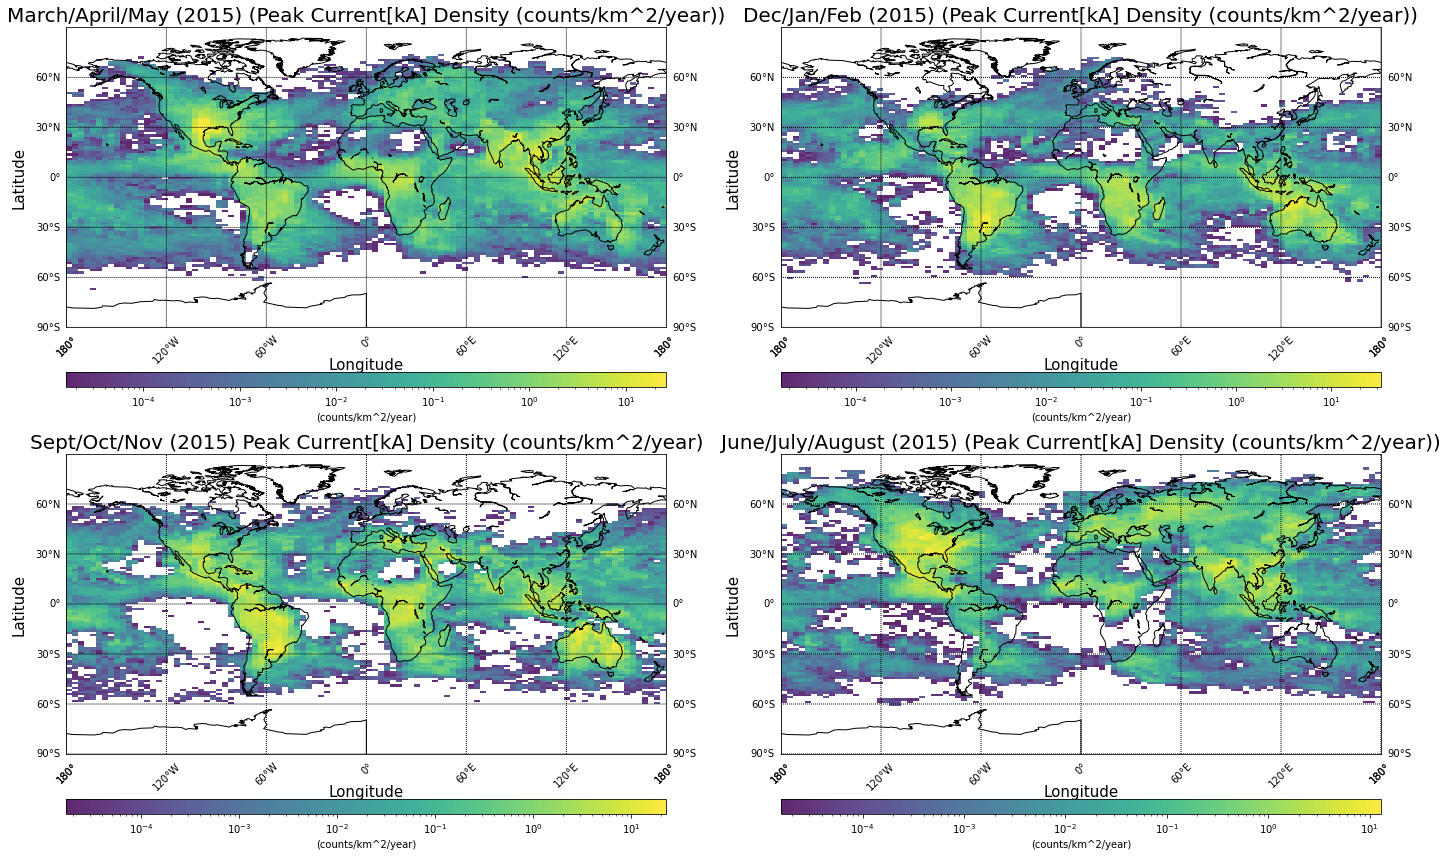

In [109]:
count = 0
for season in ["Spring", "Winter", "Fall", "Summer"]:
    file = np.load("2015/"+season+".npz") # passing in scipy stats data to plotting function
    count += 1
    plot(year = 2015, file = file, count=count, label = "Peak Current[kA] Density (counts/km^2/year)", label2 = "(counts/km^2/year)")

plt.tight_layout()
plt.savefig("2015/2015PeakCurrentOccurence", facecolor='w')

In [110]:
#dictionary = np.load('2015/Fall.npz', allow_pickle = True)
#computeCurrentDensity(dictionary)

In [111]:
# TO-DO
# Create average peak current density plot - kA/km^2/year
